[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/main)

# Gridwatch scraper

* [ ] setup with github actions
* [ ] [commit data to github](https://lannonbr.com/blog/2019-12-09-git-commit-in-actions)
* [ ] schedule as cron task
* [ ] log data to https://www.dolthub.com/

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, os.path.join(".."))

from gridwatch_scraper import *

# Change to the parent directory so that data files are stored in the right place
os.chdir('..')

"""
driver = init_driver(headless=False)
timeOfReading = load_page(driver)
scrape_summary_data(driver, timeOfReading)
df_plant_level_data = scrape_plant_level_data(driver)
get_row_from_plant_level_data(
    driver, timeOfReading, df_plant_level_data, "output"
)
get_row_from_plant_level_data(
    driver, timeOfReading, df_plant_level_data, "capability"
)
df_plant_level_data.drop(["output", "capability"], axis=1).to_csv("data/plants.csv", index=False)
"""

'\ndriver = init_driver(headless=False)\ntimeOfReading = load_page(driver)\nscrape_summary_data(driver, timeOfReading)\ndf_plant_level_data = scrape_plant_level_data(driver)\nget_row_from_plant_level_data(\n    driver, timeOfReading, df_plant_level_data, "output"\n)\nget_row_from_plant_level_data(\n    driver, timeOfReading, df_plant_level_data, "capability"\n)\ndf_plant_level_data.drop(["output", "capability"], axis=1).to_csv("data/plants.csv", index=False)\n'

No mapping for DUPONT
No mapping for NAPANEE-G1
No mapping for NAPANEE-G2
No mapping for NAPANEE-G3
Mean CO2e intensity=522.0 g/kWh


Text(0.5, 0, 'CO2e (g/kWh)')

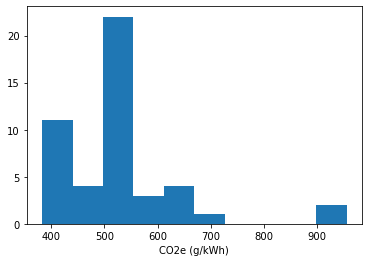

In [2]:
import numpy as np
import matplotlib.pyplot as plt

df_carma = pd.read_csv('data/CARMAv30_PowerUser/Plant.csv', low_memory=False)
df_summary = pd.read_csv("data/summary.csv", index_col=0, thousands=',')
df_capability = pd.read_csv("data/capability.csv", thousands=',')
df_plants = pd.read_csv("data/plants.csv")
df_output = pd.read_csv("data/output.csv", index_col=0, thousands=',')
df_map = pd.read_csv("data/map.csv")

gas_plants = df_plants[df_plants['source'] == 'gas']['name'].values
no_intensity_data = ['DUPONT', 'NAPANEE-G1', 'NAPANEE-G2', 'NAPANEE-G3']

df_co2e_intensity = df_output*0

for name in gas_plants:
    carma_plant_name = df_map[df_map['name'] == name]['carma_plant_name'].values[0]
    if name in no_intensity_data:
        print(f'No mapping for {name}')
    elif carma_plant_name == 'HALTON HILLS':
        df_co2e_intensity[name] = df_carma[df_carma['plant'] == carma_plant_name]['intensity_future'].values[0]
    else:
        df_co2e_intensity[name] = df_carma[df_carma['plant'] == carma_plant_name]['intensity_present'].values[0]

df_co2e_intensity[no_intensity_data] = np.nan

# Average CO2e intensity
print("Mean CO2e intensity=%.1f g/kWh" % df_co2e_intensity[gas_plants].iloc[0].dropna().mean())

# For stations with no intensity data, use the mean
#df_co2e_intensity[no_intensity_data] = df_co2e_intensity[gas_plants].iloc[0].dropna().mean()

plt.hist(df_co2e_intensity[gas_plants].iloc[0])
plt.xlabel('CO2e (g/kWh)')
#df_co2e_intensity[gas_plants].iloc[0]

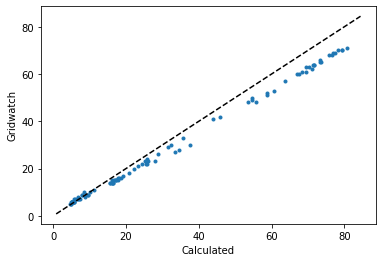

In [3]:
# Plot the grid CO2e intensity we've calculated vs the one reported by gridwatch

# Note that our values are higher than gridwatch by ~13%

plt.plot((df_co2e_intensity * df_output).sum(axis=1) / df_output.sum(axis=1),
         df_summary['CO2e INTENSITY'].str.replace(' g/kWh', '').astype(float), '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.ylabel('Gridwatch')
plt.xlabel('Calculated');

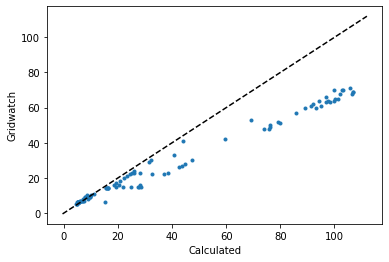

In [4]:
# For stations with no intensity data, use the mean intensity from all plants
df_co2e_intensity[no_intensity_data] = df_co2e_intensity[gas_plants].iloc[0].dropna().mean()

# Assuming the mean intensity for plants without intensity data, our values are higher than
# gridwatch by ~50%

# Plot the grid CO2e intensity we've calculated vs the one reported by gridwatch
plt.plot((df_co2e_intensity * df_output).sum(axis=1) / df_output.sum(axis=1),
         df_summary['CO2e INTENSITY'].str.replace(' g/kWh', '').astype(float), '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.ylabel('Gridwatch')
plt.xlabel('Calculated');

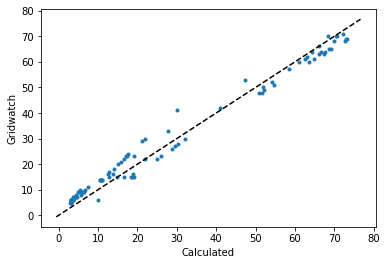

In [5]:
# Plot the grid CO2e intensity reported by gridwatch vs an average emissions intensity

average_co2e_intensity = 350
plt.plot(df_output[gas_plants].sum(axis=1)*average_co2e_intensity / df_output.sum(axis=1),
         df_summary['CO2e INTENSITY'].str.replace(' g/kWh', '').astype(float), '.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')
plt.ylabel('Gridwatch')
plt.xlabel('Calculated');

In [28]:
# Download IESO historical data
import requests

def download_url(url, ext='.xlsx'):
    filename = os.path.join('data', 'IESO', os.path.splitext(url.split('/')[-1])[0] + ext)
    if not os.path.exists(filename):
        print(f"Download { filename }")
        r = requests.get(url)
        if r.ok:
            with open(filename,'wb') as output_file:
                output_file.write(r.content)
        else:
            print("Error downloading file")

for year in range(2010, 2019):
    url = f"https://ieso.ca/-/media/Files/IESO/Power-Data/data-directory/GOC-{ year }.ashx"
    download_url(url)
    
# Special case: 2019 Jan-Apr
download_url('https://ieso.ca/-/media/Files/IESO/Power-Data/data-directory/GOC-2019-Jan-April.ashx')    

# Rest of 2019
year = 2019
for month in range(6,13):
    url = "http://reports.ieso.ca/public/GenOutputCapabilityMonth/PUB_GenOutputCapabilityMonth_%d%02d.csv" % (year, month)
    download_url(url, ext='.csv')
    
# 2020 to present
for year in range(2020, 2022):
    for month in range(1,13):
        url = "http://reports.ieso.ca/public/GenOutputCapabilityMonth/PUB_GenOutputCapabilityMonth_%d%02d.csv" % (year, month)
        download_url(url, ext='.csv')

Download data\IESO\PUB_GenOutputCapabilityMonth_202111.csv
Error downloading file
Download data\IESO\PUB_GenOutputCapabilityMonth_202112.csv
Error downloading file
